# Lab 13 Notebook - Explainability

This week, we have seen an introduction to several explainability methods, used for peeking into the black-box of your neural network model and seeing what your model finds important while making predictions. Building upon last week's topics on fairness, this lecture on explainability is especially relevant to the ethical concerns of modeling human data. 

In our lecture demo, we have seen at two different classes of AI explainability: global surrogate models (estimating the whole black box) with **Partial Dependence Plots (PDP)** and local surrogate models (explaining one instance's prediction) with **LIME**. We now want to examine whether these explanations align with each other. 

The question we aim to answer with this lab:   
> If we run a sample of local explanations on a random subset of our students, does it align with the global explanations for our model? 

If you use noto for this notebook, don't forget to use the **Tensorflow** kernel. 

**Missing files?** Make sure that you have copied all the (private, anonymized) data and models from the explainability folder of the [MLBD Lecture Drive](https://drive.google.com/drive/folders/1gUvnJvpoKpFWSGwbkGZEfeGhGeQdYypo?usp=share_link) that we shared with you.

In [1]:
# Load standard imports for the rest of the notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

DATA_DIR = "./../../data/"

In [2]:
# Load explainability imports.
from lime import lime_tabular
import shap

# Suppress TF warnings during import
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
# Set log level to DEBUG again
tf.get_logger().setLevel('DEBUG')

In [3]:
model_name = "{}/explainability/model".format(DATA_DIR)
loaded_model = tf.keras.models.load_model(model_name)

In [4]:
features = pd.read_csv('{}/explainability/mooc_features.csv'.format(DATA_DIR))
labels = pd.read_csv('{}/explainability/mooc_labels.csv'.format(DATA_DIR))['0']

In [5]:
features.shape, labels.shape

((8679, 250), (8679,))

In [6]:
# For 8,679 students, we have 10 weeks of data with 25 features per week.

display(features)

,RegPeakTimeDayHour_InWeek1,RegPeriodicityM1_InWeek1,DelayLecture_InWeek1,TotalClicks_InWeek1,NumberOfSessions_InWeek1,TotalTimeSessions_InWeek1,AvgTimeSessions_InWeek1,StdTimeBetweenSessions_InWeek1,StdTimeSessions_InWeek1,TotalClicksWeekday_InWeek1,...,TotalTimeVideo_InWeek10,CompetencyAnticipation_InWeek10,ContentAlignment_InWeek10,ContentAnticipation_InWeek10,StudentSpeed_InWeek10,TotalClicksVideoLoad_InWeek10,AvgWatchedWeeklyProp_InWeek10,AvgReplayedWeeklyProp_InWeek10,TotalClicksVideoConati_InWeek10,FrequencyEventLoad_InWeek10
0,3.178054,1.000000e+00,-518326.0,1.0,0.0,0.0,0.000000,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
1,7.058606,3.041330e+00,-497116.5,34.0,3.0,5423.0,1807.666667,90701.5,1158.870811,26.0,...,10683.0,0.0,0.8,0.0,558.00,16.0,0.8,0.2,16.0,0.666667
2,5.703059,3.092002e+00,-481356.0,7.0,0.0,0.0,0.000000,0.0,0.000000,7.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
3,6.929695,2.435539e+00,-427158.0,20.0,2.0,4804.0,2402.000000,0.0,998.000000,12.0,...,5325.0,0.0,1.0,0.0,2074.25,16.0,1.0,0.0,16.0,0.301887
4,12.712215,1.000000e+00,-517640.0,4.0,1.0,863.0,863.000000,0.0,0.000000,4.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8674,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8675,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8676,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8677,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000


In [7]:
# For our true labels, we have a pass (0) or fail (1) performance indicator. We only use these labels after obtaining model
# explanations, to try to understand how our model performs against the ground truth.

# There are 8,679 students in this MOOC course.

display(labels)

0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
8674    1.0
8675    1.0
8676    1.0
8677    1.0
8678    1.0
Name: 0, Length: 8679, dtype: float64

In [8]:
# This function returns a (NUM OF INSTANCES, 2) array of probability of pass in first column and 
# probability of failing in another column, which is the format LIME requires.
predict_fn = lambda x: np.array([[1-loaded_model.predict(x)],
                                 [loaded_model.predict(x)]]).reshape(2,-1).T

In [9]:
class_names = ['pass', 'fail']

# We initialize the LIME explainer on our training data.
explainer = lime_tabular.LimeTabularExplainer(
      training_data=np.array(features),
      feature_names=features.columns,
      class_names=class_names,
      mode='classification',
      discretize_continuous=True)

## LIME: Generate local explanations with LIME (for multiple students)

#### Your Turn: Select a subset of students

In [10]:
# Select 10 instances (student numbers) to explain with LIME. 
# These can be randomly selected, or chosen based on certain criteria.

instances = list(range(11))

In [12]:
def plot_lime(exp, instance_id):
    s = 'fail' if labels[instance_id] else 'pass'
    label = exp.available_labels()[0]
    expl = exp.as_list(label=label)
    fig = plt.figure(facecolor='white')
    vals = [x[1] for x in expl]
    names = [x[0] for x in expl]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(expl)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    prediction = loaded_model.predict(np.array(features.iloc[instance_id]).reshape(1,250))[0][0]
    prediction = np.round(1-prediction, 2)
    print("Student #: ", instance_id)
    print("Ground Truth Model Prediction: ", 1-labels[instance_id], "-", s)
    print("Black Box Model Prediction: ", prediction, "-", 'pass' if prediction > 0.5 else 'fail')

In [13]:
def DataFrame_all(explainers,instances,real_labels):
    df=pd.DataFrame({})
    class_names=['pass', 'fail']
    dfl=[]
    for i,exp in enumerate(explainers):
        this_label=exp.available_labels()[0]
        l=[]
        l.append(("exp number",instances[i]))
        l.append(("real value",'fail' if real_labels[instances[i]] else 'pass'))
        l.extend(exp.as_list(label=this_label))
        dfl.append(dict(l))
    df=pd.concat((df, pd.DataFrame(dfl)))
    return df

In [14]:
explainers = []
for instance_id in instances:
    # This line calls our LIME explainer on a student instance.
    # Note the num_features=10 attribute -- this number is the default, but it could be changed if you would like LIME to predict more or fewer features.
    explainers.append(explainer.explain_instance(features.iloc[instance_id], predict_fn, num_features=10))

Student #:  0
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.4 - fail


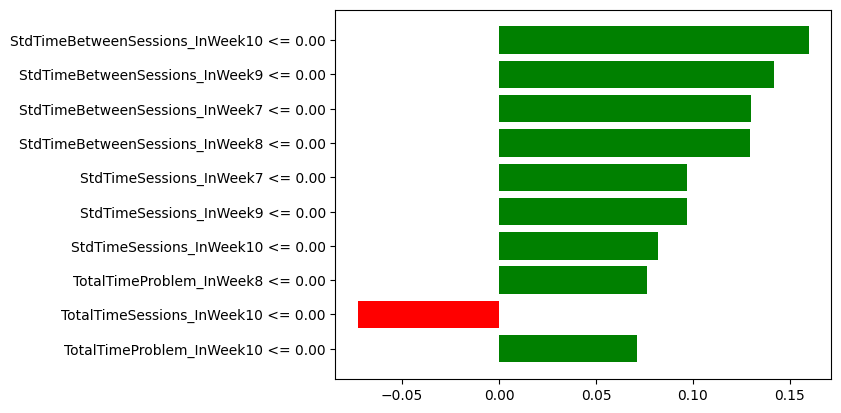

Student #:  1
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.37 - fail


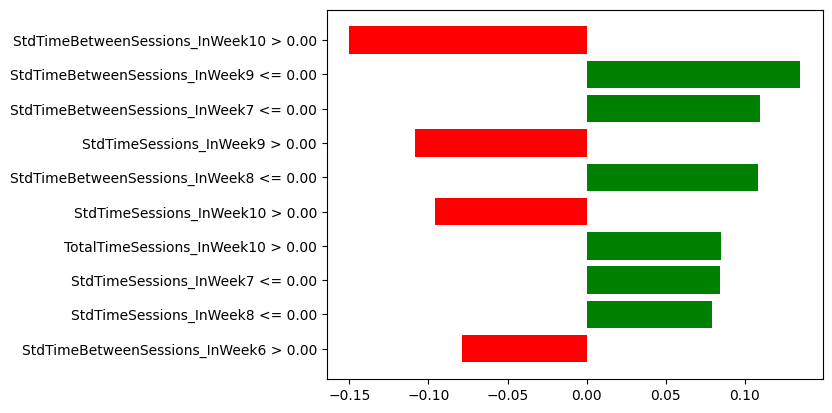

Student #:  2
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.39 - fail


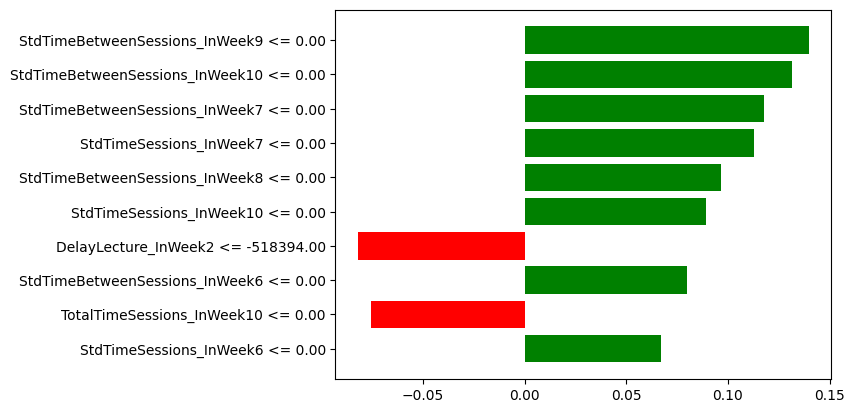

Student #:  3
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.51 - pass


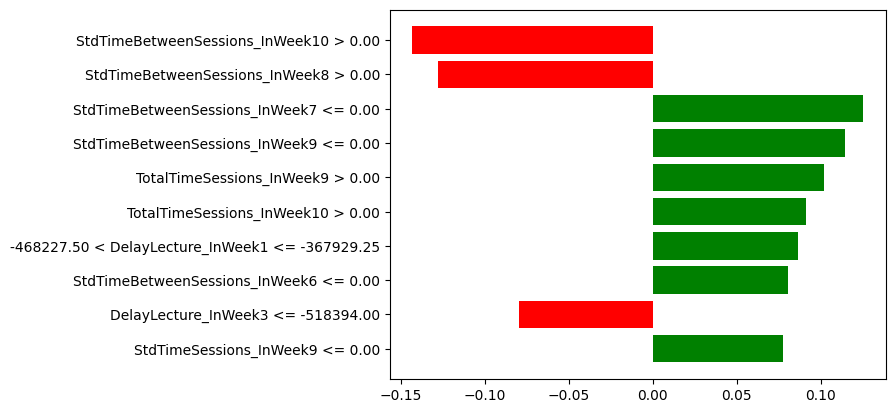

Student #:  4
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.4 - fail


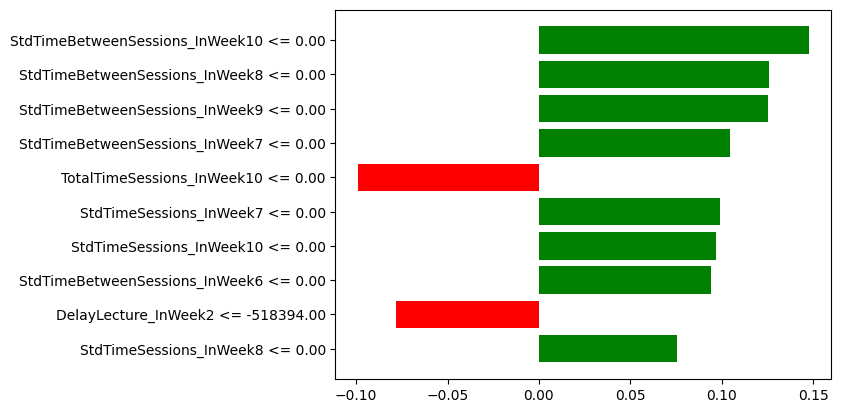

Student #:  5
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.4 - fail


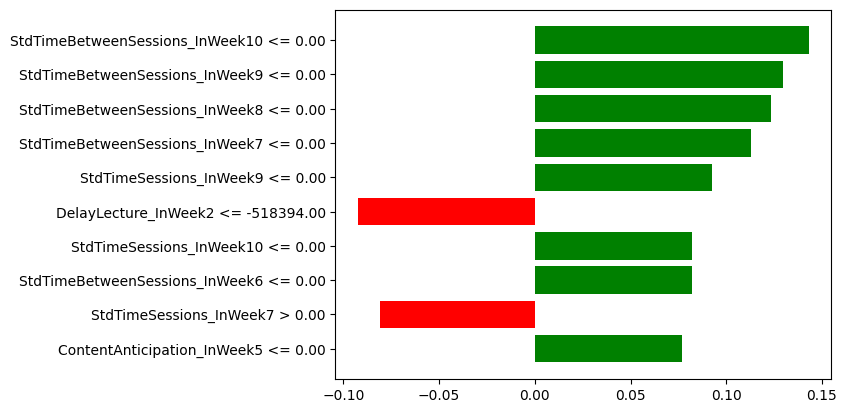

Student #:  6
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.3 - fail


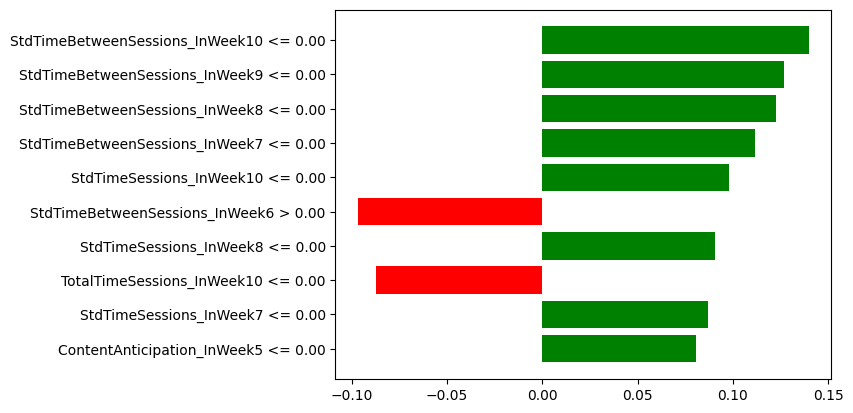

Student #:  7
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.55 - pass


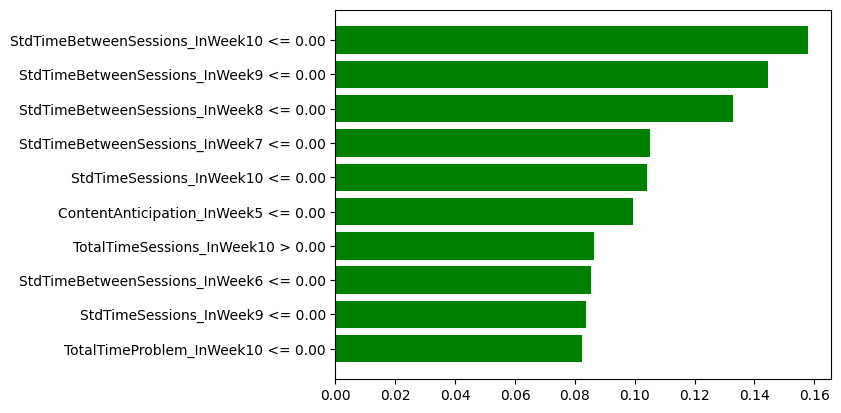

Student #:  8
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.38 - fail


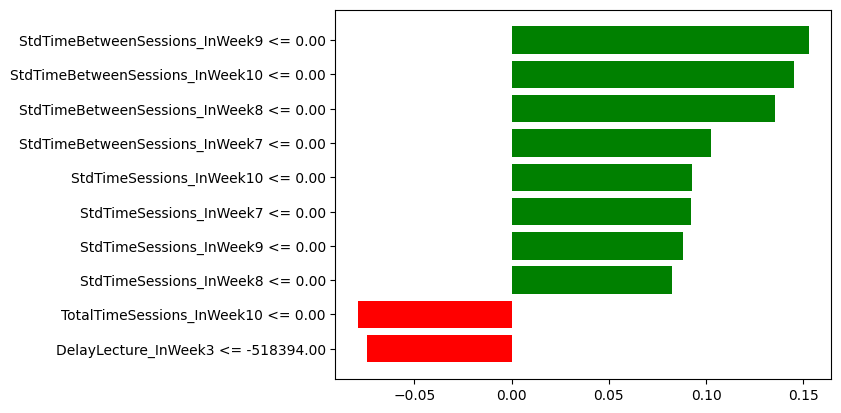

Student #:  9
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.67 - pass


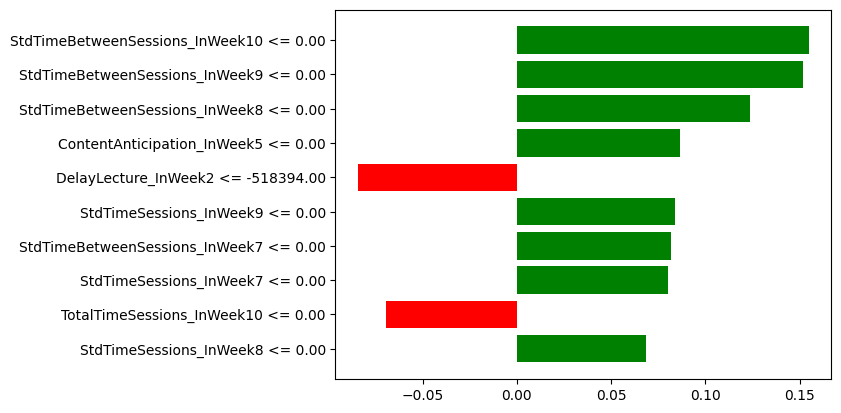

Student #:  10
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.39 - fail


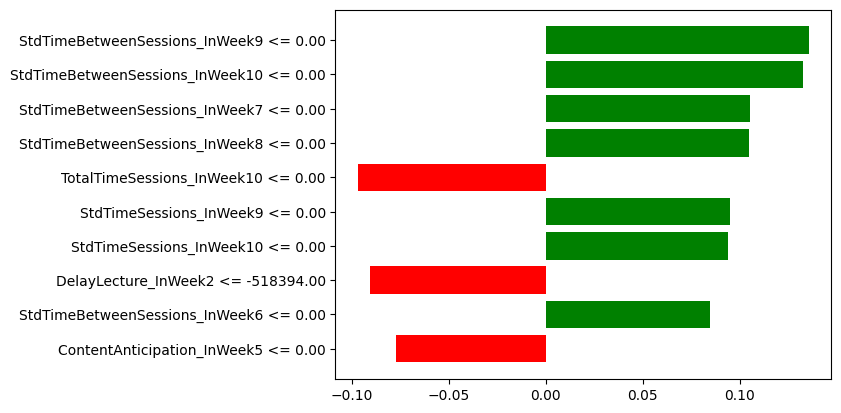

In [15]:
# Generate LIME plots for the chosen students.

for exp, instance_id in zip(explainers, instances):
    plot_lime(exp, instance_id)
    plt.show()

In [16]:
# Aggregate LIME feature importances (across students) into dataframe for later analysis.

df = DataFrame_all(explainers,instances,labels)

In [17]:
df

,exp number,real value,StdTimeBetweenSessions_InWeek10 <= 0.00,StdTimeBetweenSessions_InWeek9 <= 0.00,StdTimeBetweenSessions_InWeek7 <= 0.00,StdTimeBetweenSessions_InWeek8 <= 0.00,StdTimeSessions_InWeek7 <= 0.00,StdTimeSessions_InWeek9 <= 0.00,StdTimeSessions_InWeek10 <= 0.00,TotalTimeProblem_InWeek8 <= 0.00,...,StdTimeBetweenSessions_InWeek6 > 0.00,DelayLecture_InWeek2 <= -518394.00,StdTimeBetweenSessions_InWeek6 <= 0.00,StdTimeSessions_InWeek6 <= 0.00,StdTimeBetweenSessions_InWeek8 > 0.00,TotalTimeSessions_InWeek9 > 0.00,-468227.50 < DelayLecture_InWeek1 <= -367929.25,DelayLecture_InWeek3 <= -518394.00,StdTimeSessions_InWeek7 > 0.00,ContentAnticipation_InWeek5 <= 0.00
0,0,fail,0.159872,0.141886,0.129883,0.129228,0.097041,0.096727,0.081936,0.076205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,pass,NaN,0.135096,0.109736,0.108216,0.084287,NaN,NaN,NaN,...,-0.078857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,fail,0.131266,0.139830,0.117744,0.096682,0.112609,NaN,0.089250,NaN,...,NaN,-0.081974,0.080084,0.067295,NaN,NaN,NaN,NaN,NaN,NaN
3,3,pass,NaN,0.114579,0.125380,NaN,NaN,0.077443,NaN,NaN,...,NaN,NaN,0.080469,NaN,-0.127804,0.101712,0.08623,-0.079429,NaN,NaN
4,4,fail,0.147731,0.125203,0.104480,0.125643,0.098886,NaN,0.097002,NaN,...,NaN,-0.078077,0.094230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,pass,0.143211,0.129689,0.112690,0.123235,NaN,0.092657,0.082240,NaN,...,NaN,-0.092390,0.081862,NaN,NaN,NaN,NaN,NaN,-0.080985,0.076660
6,6,pass,0.139971,0.126727,0.111581,0.122614,0.087030,NaN,0.097985,NaN,...,-0.096797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080567
7,7,fail,0.157852,0.144538,0.104939,0.132925,NaN,0.083626,0.104008,NaN,...,NaN,NaN,0.085525,NaN,NaN,NaN,NaN,NaN,NaN,0.099585
8,8,fail,0.144970,0.152833,0.102506,0.135498,0.092152,0.088147,0.092609,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.074319,NaN,NaN
9,9,pass,0.154979,0.151769,0.082003,0.123712,0.080339,0.084016,NaN,NaN,...,NaN,-0.084229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086401


## PDP: Generate global explanations with PDP

In [18]:
# We generate the PDP plot against a background distribution of all the points available in the feature set.
# While a minimal background distribution would let us run this analysis faster (i.e. 300 points), we recommend 
# plotting with a much larger point distribution (all the students) if you use this in other situations for 
# improved accuracy and a more global understanding of your model's behavior.

background_distribution = features

In [19]:
# This function converts our data to the right format for the PDP explainer.

predict_fn = lambda x: (1 - loaded_model.predict(x)).flatten()

#### Your Turn: Select a subset of features to analyze

In [20]:
# Based on the above analysis, select at least two features to analyze with PDP.

features_to_analyze = ['StdTimeBetweenSessions_InWeek10','StdTimeBetweenSessions_InWeek9']

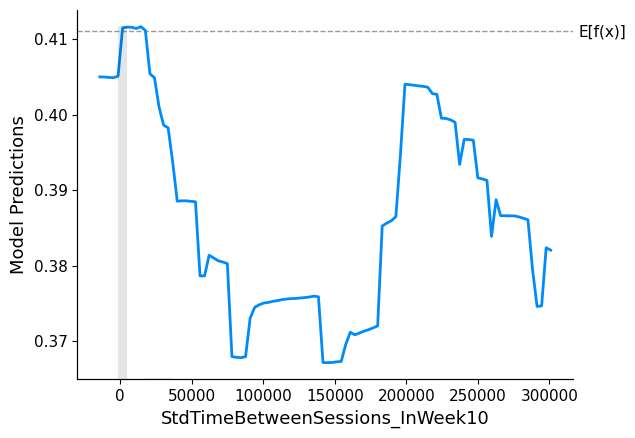

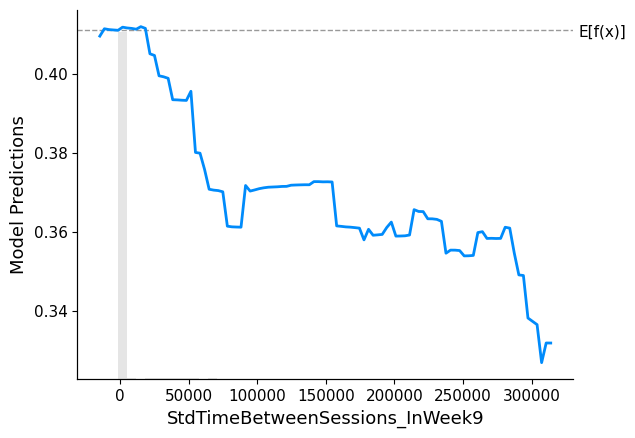

In [21]:
# Generate partial dependence plots for your chosen features.

for feature in features_to_analyze:
    feat = list(features.columns).index(feature) 
    # Create a PDP from the background distribution.
    fig = shap.plots.partial_dependence(
      feat, predict_fn, background_distribution, ice=False, ylabel='Model Predictions',
      model_expected_value=True, feature_expected_value=False, show=True
    )

### Comparing Global and Local Explanations

Choose two features selected as important by the LIME explanations and interpret the PDP plot. Do the LIME explanations' important features correspond with the PDP analysis of that feature?

How can global and local explanation be used together?

In [ ]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lab-13',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

In [ ]:
interpretation = """
Write your interpretation of the local vs. global analysis for feature 1 here.
"""

send(interpretation, 1)

In [ ]:
interpretation = """
Write your interpretation of the local vs. global analysis for feature 2 here.
"""

send(interpretation, 2)